In [1]:
import sys
from pathlib import Path
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score, accuracy_score
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import time
# import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

from config import config

plt.style.use('default')
sns.set_palette("husl")

In [17]:

# Load structured features
structured_data = np.load("../models/structured_features.npz")
X_structured_train = structured_data['X_train']
X_structured_test = structured_data['X_test']
y_structured_train = structured_data['y_train']
y_structured_test = structured_data['y_test']
structured_feature_names = structured_data['feature_names']

# Load text features  
text_data = np.load("../models/text_features.npz")
X_text_train = text_data['X_train']
X_text_test = text_data['X_test'] 
y_text_train = text_data['y_train']
y_text_test = text_data['y_test']
text_feature_names = text_data['feature_names']

# Load image features
image_data = np.load("../src/models/image_features.npz")
X_image_train = image_data['X_train'] 
X_image_test = image_data['X_test']
y_image_train = image_data['y_train']
y_image_test = image_data['y_test'] 
image_feature_names = image_data['feature_names']

# Use structured labels as master labels
y_train = y_structured_train
y_test = y_structured_test

In [18]:
print(f"\n✅ Image features loaded:")
print(f"   Train: {X_image_train.shape}, Test: {X_image_test.shape}")
print(f"   Features: {list(image_feature_names)}")


✅ Image features loaded:
   Train: (6677, 2), Test: (1563, 2)
   Features: ['max_image_similarity', 'avg_image_similarity']


In [20]:
# Check the contents of your image_features.npz file

import numpy as np
from pathlib import Path

# Load the image features file
image_features_path = Path("../src/models/image_features.npz")

if image_features_path.exists():
    print("Loading image_features.npz...")
    image_data = np.load(image_features_path)
    
    print(f"Keys in the file: {list(image_data.keys())}")
    
    # Check the main feature arrays
    if 'X_train' in image_data:
        X_train = image_data['X_train']
        print(f"\nX_train shape: {X_train.shape}")
        print(f"X_train data type: {X_train.dtype}")
        print(f"X_train range: [{X_train.min():.6f}, {X_train.max():.6f}]")
        print(f"X_train mean: {X_train.mean():.6f}")
        print(f"Non-zero values: {np.count_nonzero(X_train)}/{X_train.size}")
        
        # Check first few samples
        print(f"First 5 samples of X_train:")
        for i in range(min(5, len(X_train))):
            print(f"  Sample {i}: {X_train[i]}")
    
    if 'X_test' in image_data:
        X_test = image_data['X_test']
        print(f"\nX_test shape: {X_test.shape}")
        print(f"X_test range: [{X_test.min():.6f}, {X_test.max():.6f}]")
        print(f"X_test mean: {X_test.mean():.6f}")
        print(f"Non-zero values: {np.count_nonzero(X_test)}/{X_test.size}")
    
    # Check embeddings if they exist
    if 'embeddings_train_A' in image_data:
        embeddings_A = image_data['embeddings_train_A']
        print(f"\nEmbeddings A shape: {embeddings_A.shape}")
        print(f"Embeddings A range: [{embeddings_A.min():.6f}, {embeddings_A.max():.6f}]")
        print(f"Embeddings A mean: {embeddings_A.mean():.6f}")
    
    # Feature names
    if 'feature_names' in image_data:
        feature_names = image_data['feature_names']
        print(f"\nFeature names: {feature_names}")
    
    print(f"\nFILE STATUS:")
    if X_train.max() == 0.0 and X_train.min() == 0.0:
        print("❌ Image features are all zeros - need to re-extract")
    else:
        print("✅ Image features contain meaningful data")
        
else:
    print("❌ image_features.npz file not found!")
    print("You need to run the image extraction section in notebook 03")

Loading image_features.npz...
Keys in the file: ['X_train', 'X_test', 'embeddings_train_A', 'embeddings_train_B', 'embeddings_test_A', 'embeddings_test_B', 'y_train', 'y_test', 'feature_names']

X_train shape: (6677, 2)
X_train data type: float64
X_train range: [-1.717763, 1.581555]
X_train mean: -0.000000
Non-zero values: 13354/13354
First 5 samples of X_train:
  Sample 0: [0.93604672 0.49998798]
  Sample 1: [0.93604672 0.49998798]
  Sample 2: [0.93604735 0.68699619]
  Sample 3: [-1.70509955 -1.7177631 ]
  Sample 4: [-1.70509955 -1.7177631 ]

X_test shape: (1563, 2)
X_test range: [-1.717763, 1.366859]
X_test mean: 0.032840
Non-zero values: 3126/3126

Embeddings A shape: (6677, 2048)
Embeddings A range: [0.000000, 6.947721]
Embeddings A mean: 0.354311

Feature names: ['max_image_similarity' 'avg_image_similarity']

FILE STATUS:
✅ Image features contain meaningful data


In [4]:
## Training model on structured data only


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.random_state)

model_configs = {
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=config.random_state, eval_metric='logloss'),
        'search_space': {
            'n_estimators': Integer(100, 500),
            'max_depth': Integer(3, 8),
            'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
            'min_child_weight': Integer(1, 10),
            'subsample': Real(0.6, 1.0),
            'colsample_bytree': Real(0.6, 1.0),
            'reg_alpha': Real(0.0, 1.0),
            'reg_lambda': Real(0.0, 1.0)
        },
        'n_iter': 50
    },
    
    'RandomForest': {
        'model': RandomForestClassifier(random_state=config.random_state, n_jobs=-1),
        'search_space': {
            'n_estimators': Integer(100, 500),
            'max_depth': Integer(5, 20),
            'min_samples_split': Integer(2, 20),
            'min_samples_leaf': Integer(1, 10),
            'max_features': Categorical(['sqrt', 'log2', 0.5, 0.7]),
            'bootstrap': Categorical([True, False])
        },
        'n_iter': 30
    },
    
    'LogisticRegression': {
        'model': LogisticRegression(random_state=config.random_state, max_iter=1000),
        'search_space': {
            'C': Real(0.01, 100, prior='log-uniform'),
            'penalty': Categorical(['l1', 'l2', 'elasticnet']),
            'solver': Categorical(['liblinear', 'saga']),
            'l1_ratio': Real(0.0, 1.0)
        },
        'n_iter': 20
    }
}



In [5]:
model_results = {}


for model_name, config_dict in model_configs.items():
    
    start_time = time.time()
    
    try:
        # Handle special cases for LogisticRegression
        if model_name == 'LogisticRegression':
            # LogisticRegression doesn't support all penalty-solver combinations
            search_space = {
                'C': Real(0.01, 100, prior='log-uniform'),
                'penalty': Categorical(['l2']),  # Simplified for stability
                'solver': Categorical(['lbfgs'])
            }
            n_iter = 15
        else:
            search_space = config_dict['search_space']
            n_iter = config_dict['n_iter']
        
        bayes_search = BayesSearchCV(
            estimator=config_dict['model'],
            search_spaces=search_space,
            n_iter=n_iter,
            cv=cv,
            scoring='f1',
            n_jobs=-1,
            random_state=config.random_state,
            verbose=1
        )
        
        bayes_search.fit(X_structured_train, y_train)
        
        best_model = bayes_search.best_estimator_
        best_params = bayes_search.best_params_
        best_cv_score = bayes_search.best_score_

        training_time = time.time() - start_time
        
        test_predictions = best_model.predict_proba(X_structured_test)[:, 1]

        # Evaluate on test set
        y_pred = best_model.predict(X_structured_test)
        y_pred_proba = best_model.predict_proba(X_structured_test)[:, 1]
        
        
        # # Find optimal threshold
        # optimal_threshold, opt_precision, opt_recall, opt_f1 = find_optimal_threshold(
        #     y_test, test_predictions, target_precision=0.85
        # )
        
        # # Final test metrics
        # test_pred_binary = (test_predictions >= optimal_threshold).astype(int)
        # final_precision = precision_score(y_test, test_pred_binary)
        # final_recall = recall_score(y_test, test_pred_binary)
        # final_f1 = f1_score(y_test, test_pred_binary)
        # final_accuracy = accuracy_score(y_test, test_pred_binary)
        # final_auc = roc_auc_score(y_test, test_predictions)
        # Calculate test metrics
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred_proba)
        
        
        
        print(f"Optimization complete!")
        print(f"Best CV F1 score: {best_cv_score:.4f}")
        print(f"Training time: {training_time:.1f}s")
        print(f"\nTest Performance:")
        print(f"  Accuracy:  {test_accuracy:.4f}")
        print(f"  Precision: {test_precision:.4f}")
        print(f"  Recall:    {test_recall:.4f}")
        print(f"  F1-Score:  {test_f1:.4f}")
        print(f"  AUC:       {test_auc:.4f}")

        # Check targets
        meets_precision = test_precision >= 0.85
        meets_f1 = test_f1 >= 0.80
        print(f"Precision target (>=0.85): {'✅' if meets_precision else '❌'}")
        print(f"F1 target (>=0.80):        {'✅' if meets_f1 else '❌'}")
        

        model_results[model_name] = {
            'model': best_model,
            'best_params': best_params,
            'cv_score': best_cv_score,
            'test_predictions': y_pred,
            'test_predictions_proba': y_pred_proba,
            'metrics': {
                'accuracy': test_accuracy,
                'precision': test_precision,
                'recall': test_recall,
                'f1': test_f1,
                'auc': test_auc
            },
            'training_time': training_time,
            'meets_precision_target': meets_precision,
            'meets_f1_target': meets_f1
        }

        # Print best parameters (top 5)
        print(f"\nBest Parameters:")
        param_items = list(best_params.items())
        for param, value in param_items[:5]:
            print(f"  {param}: {value}")
        if len(param_items) > 5:
            print(f"  ... and {len(param_items) - 5} more parameters")
            
    except Exception as e:
        print(f" {model_name} failed: {str(e)}")
        model_results[model_name] = {
            'error': str(e),
            'training_time': time.time() - start_time
        }



Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [6]:
successful_models = {k: v for k, v in model_results.items() if 'error' not in v}

if successful_models:
    # Create comparison DataFrame
    comparison_data = []
    for name, result in successful_models.items():
        metrics = result['metrics']
        comparison_data.append({
            'Model': name,
            'CV_F1': f"{result['cv_score']:.4f}",
            'Test_Accuracy': f"{metrics['accuracy']:.4f}",
            'Test_Precision': f"{metrics['precision']:.4f}",
            'Test_Recall': f"{metrics['recall']:.4f}",
            'Test_F1': f"{metrics['f1']:.4f}",
            'Test_AUC': f"{metrics['auc']:.4f}",
            'Training_Time': f"{result['training_time']:.1f}s",
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Filter models meeting precision target
    qualified_models = {k: v for k, v in successful_models.items() 
                       if v['meets_precision_target']}
    
    if qualified_models:
        best_model_name = max(qualified_models.keys(), 
                             key=lambda k: qualified_models[k]['metrics']['f1'])
        best_result = qualified_models[best_model_name]
        print(f"\nSELECTED MODEL: {best_model_name}")
        
    else:
        # No model meets precision target, select best F1
        best_model_name = max(successful_models.keys(), 
                             key=lambda k: successful_models[k]['metrics']['f1'])
        best_result = successful_models[best_model_name]
        print(f"\nBEST AVAILABLE MODEL: {best_model_name}")
        print(f"   (No model met precision target of >=0.85)")
    
    # Print selected model details
    metrics = best_result['metrics']
    print(f"\nSelected Model Performance:")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    print(f"  AUC:       {metrics['auc']:.4f}")
    print(f"  Training:  {best_result['training_time']:.1f}s")
    
    # Feature importance analysis
    best_model = best_result['model']
    print(f"\nFeature Importance Analysis:")
    
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': structured_feature_names,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("Top 5 Most Important Features:")
        for idx, row in importance_df.head().iterrows():
            print(f"  {row['Feature']:<25}: {row['Importance']:.4f}")
            
    elif hasattr(best_model, 'coef_'):
        coef_df = pd.DataFrame({
            'Feature': structured_feature_names,
            'Coefficient': best_model.coef_[0]
        })
        coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
        coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
        
        print("Top 5 Most Important Features (by coefficient magnitude):")
        for idx, row in coef_df.head().iterrows():
            print(f"  {row['Feature']:<25}: {row['Coefficient']:>7.4f}")
    
    # Confusion matrix for best model
    print(f"\nConfusion Matrix ({best_model_name}):")
    cm = confusion_matrix(y_test, best_result['test_predictions'])
    print(f"                Predicted")
    print(f"Actual    Negative  Positive")
    print(f"Negative    {cm[0,0]:4d}     {cm[0,1]:4d}")
    print(f"Positive    {cm[1,0]:4d}     {cm[1,1]:4d}")
    
    # Additional detailed metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"\nDetailed Classification Metrics:")
    print(f"  True Positives:   {tp:4d}")
    print(f"  False Positives:  {fp:4d}")
    print(f"  True Negatives:   {tn:4d}")
    print(f"  False Negatives:  {fn:4d}")
    print(f"  Specificity:      {specificity:.4f}")
    print(f"  NPV:              {npv:.4f}")
    
    # Store the selected model for later use
    structured_model = best_result['model']
    structured_predictions = best_result['test_predictions_proba']
    
    print(f"Selected: {best_model_name} with F1={metrics['f1']:.3f}, Precision={metrics['precision']:.3f}")
    
else:
    print("All models failed to train successfully")
    print("Check data quality and model configurations")

             Model  CV_F1 Test_Accuracy Test_Precision Test_Recall Test_F1 Test_AUC Training_Time
           XGBoost 0.9750        0.9840         0.9772      0.9434  0.9600   0.9986         28.4s
      RandomForest 0.9758        0.9859         0.9805      0.9497  0.9649   0.9984         25.6s
LogisticRegression 0.9670        0.9885         0.9518      0.9937  0.9723   0.9993          1.4s

SELECTED MODEL: LogisticRegression

Selected Model Performance:
  Precision: 0.9518
  Recall:    0.9937
  F1-Score:  0.9723
  AUC:       0.9993
  Training:  1.4s

Feature Importance Analysis:
Top 5 Most Important Features (by coefficient magnitude):
  surface_similarity       : 14.2109
  structured_consistency   :  6.2691
  price_similarity         :  2.7811
  room_match               :  2.7237
  price_per_m2_consistency : -2.2118

Confusion Matrix (LogisticRegression):
                Predicted
Actual    Negative  Positive
Negative    1229       16
Positive       2      316

Detailed Classification 

🏆 FINAL STRUCTURED MODEL PERFORMANCE:
   Model: LogisticRegression
   Accuracy:  0.9885
   Precision: 0.9518 ✅
   Recall:    0.9937
   F1-Score:  0.9723 ✅
   AUC:       0.9993


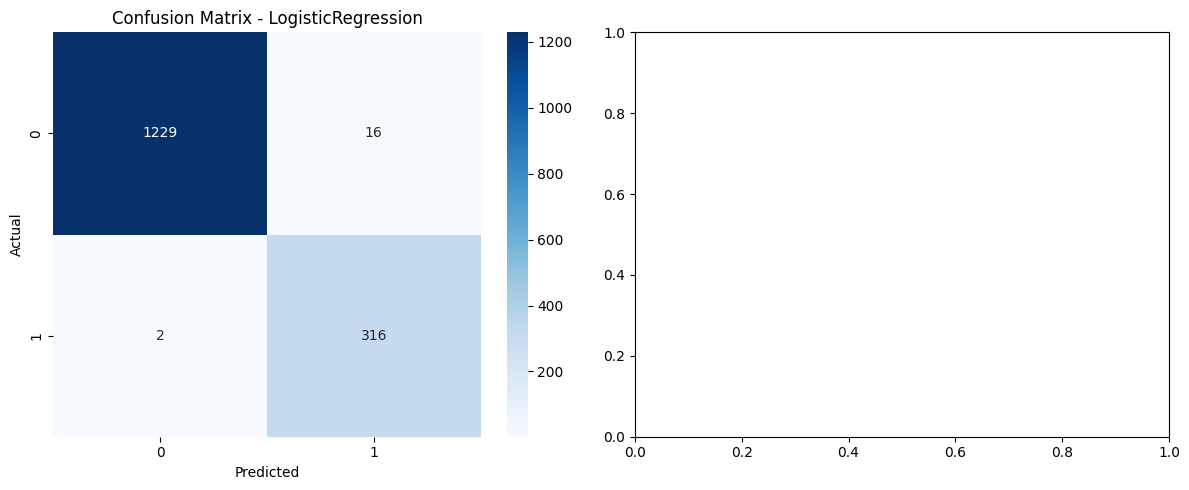


💾 SAVED:
   Model: ../models/structured_model.pkl
   Results: ../models/structured_results.pkl


In [7]:
## Model Evaluation & Storage

# Quick evaluation of the selected model
y_pred = structured_model.predict(X_structured_test)
y_pred_proba = structured_model.predict_proba(X_structured_test)[:, 1]

# Calculate final metrics
final_accuracy = accuracy_score(y_test, y_pred)
final_precision = precision_score(y_test, y_pred)
final_recall = recall_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, y_pred_proba)

print(f"🏆 FINAL STRUCTURED MODEL PERFORMANCE:")
print(f"   Model: {best_model_name}")
print(f"   Accuracy:  {final_accuracy:.4f}")
print(f"   Precision: {final_precision:.4f} {'✅' if final_precision >= 0.85 else '❌'}")
print(f"   Recall:    {final_recall:.4f}")
print(f"   F1-Score:  {final_f1:.4f} {'✅' if final_f1 >= 0.80 else '❌'}")
print(f"   AUC:       {final_auc:.4f}")

# Quick visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=ax1, cmap='Blues')
ax1.set_title(f'Confusion Matrix - {best_model_name}')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Feature Importance
if hasattr(structured_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': structured_feature_names,
        'Importance': structured_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    ax2.barh(importance_df['Feature'], importance_df['Importance'])
    ax2.set_title(f'Feature Importance - {best_model_name}')
    ax2.set_xlabel('Importance')

plt.tight_layout()
plt.savefig('../data/processed/structured_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save the model and results
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Save trained model
model_path = models_dir / "structured_model.pkl"
joblib.dump(structured_model, model_path)

# Save predictions for ensemble
predictions_data = {
    'train_predictions': structured_model.predict_proba(X_structured_train)[:, 1],
    'test_predictions': y_pred_proba,
    'model_name': best_model_name,
    'metrics': {
        'accuracy': final_accuracy,
        'precision': final_precision,
        'recall': final_recall,
        'f1': final_f1,
        'auc': final_auc
    }
}

predictions_path = models_dir / "structured_results.pkl"
joblib.dump(predictions_data, predictions_path)

print(f"\n💾 SAVED:")
print(f"   Model: {model_path}")
print(f"   Results: {predictions_path}")

Text similarity statistics:
   Train range: [-2.641, 1.698]
   Test range:  [-2.580, 1.698]
   Train mean:  0.000
   Test mean:   -0.069

Optimizing text similarity threshold...
   Best threshold: 0.850
   Best F1 score: 0.882

TEXT MODEL PERFORMANCE:
   Threshold:  0.850
   Accuracy:   0.9552
   Precision:  0.9526
   Recall:     0.8208
   F1-Score:   0.8818
   AUC:        0.8980


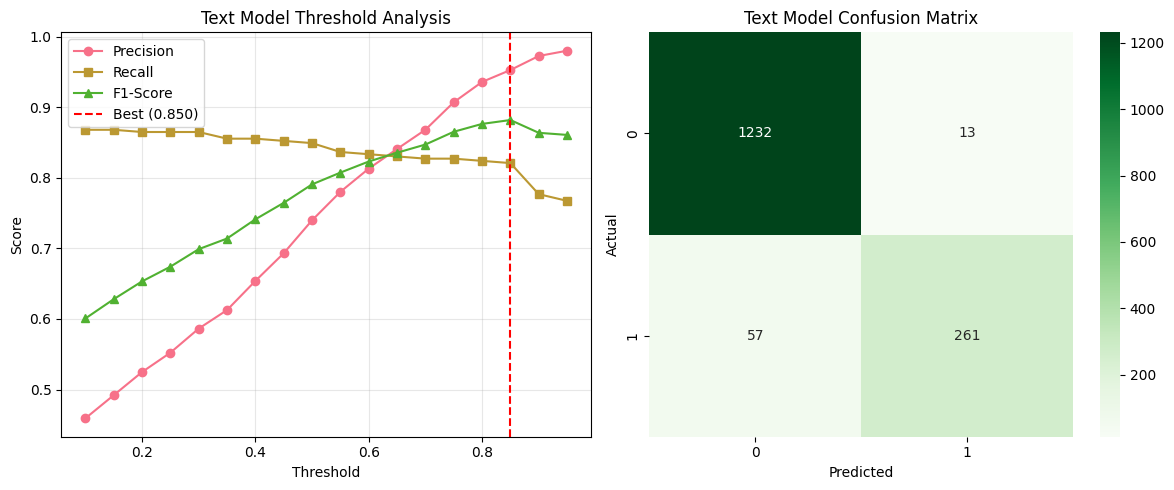


💾 Text model results saved: ../models/text_results.pkl


In [8]:
##  Text Model Training

text_similarities_train = X_text_train[:, 0]  # semantic_similarity feature
text_similarities_test = X_text_test[:, 0]

print(f"Text similarity statistics:")
print(f"   Train range: [{text_similarities_train.min():.3f}, {text_similarities_train.max():.3f}]")
print(f"   Test range:  [{text_similarities_test.min():.3f}, {text_similarities_test.max():.3f}]")
print(f"   Train mean:  {text_similarities_train.mean():.3f}")
print(f"   Test mean:   {text_similarities_test.mean():.3f}")

# Simple threshold optimization
def find_best_threshold(y_true, similarities, target_metric='f1'):
    """Find best threshold for binary classification"""
    thresholds = np.arange(0.1, 1.0, 0.05)
    best_score = 0
    best_threshold = 0.5
    
    results = []
    
    for threshold in thresholds:
        y_pred = (similarities >= threshold).astype(int)
        
        if len(np.unique(y_pred)) > 1:  # Avoid division by zero
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            
            results.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
            
            if target_metric == 'f1' and f1 > best_score:
                best_score = f1
                best_threshold = threshold
    
    return best_threshold, best_score, results

print("\nOptimizing text similarity threshold...")
best_text_threshold, best_text_score, threshold_results = find_best_threshold(
    y_test, text_similarities_test, target_metric='f1'
)

print(f"   Best threshold: {best_text_threshold:.3f}")
print(f"   Best F1 score: {best_text_score:.3f}")

# Evaluate text model with best threshold
text_pred = (text_similarities_test >= best_text_threshold).astype(int)

text_accuracy = accuracy_score(y_test, text_pred)
text_precision = precision_score(y_test, text_pred)
text_recall = recall_score(y_test, text_pred)
text_f1 = f1_score(y_test, text_pred)
text_auc = roc_auc_score(y_test, text_similarities_test)

print(f"\nTEXT MODEL PERFORMANCE:")
print(f"   Threshold:  {best_text_threshold:.3f}")
print(f"   Accuracy:   {text_accuracy:.4f}")
print(f"   Precision:  {text_precision:.4f}")
print(f"   Recall:     {text_recall:.4f}")
print(f"   F1-Score:   {text_f1:.4f}")
print(f"   AUC:        {text_auc:.4f}")

# Quick visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Threshold analysis plot
thresholds_df = pd.DataFrame(threshold_results)
ax1.plot(thresholds_df['threshold'], thresholds_df['precision'], label='Precision', marker='o')
ax1.plot(thresholds_df['threshold'], thresholds_df['recall'], label='Recall', marker='s')
ax1.plot(thresholds_df['threshold'], thresholds_df['f1'], label='F1-Score', marker='^')
ax1.axvline(x=best_text_threshold, color='red', linestyle='--', label=f'Best ({best_text_threshold:.3f})')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Text Model Threshold Analysis')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Confusion matrix
cm_text = confusion_matrix(y_test, text_pred)
sns.heatmap(cm_text, annot=True, fmt='d', ax=ax2, cmap='Greens')
ax2.set_title(f'Text Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('../data/processed/text_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save text model results
text_results = {
    'threshold': best_text_threshold,
    'train_similarities': text_similarities_train,
    'test_similarities': text_similarities_test,
    'test_predictions': text_pred,
    'metrics': {
        'accuracy': text_accuracy,
        'precision': text_precision,
        'recall': text_recall,
        'f1': text_f1,
        'auc': text_auc
    }
}

# Save to models directory
text_path = models_dir / "text_results.pkl"
joblib.dump(text_results, text_path)

print(f"\n💾 Text model results saved: {text_path}")

In [11]:
print(X_image_train)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [21]:
## Image Model Training


image_similarities_train = X_image_train[:, 0]  # max_image_similarity feature
image_similarities_test = X_image_test[:, 0]

print(f"Image similarity statistics:")
print(f"   Train range: [{image_similarities_train.min():.3f}, {image_similarities_train.max():.3f}]")
print(f"   Test range:  [{image_similarities_test.min():.3f}, {image_similarities_test.max():.3f}]")
print(f"   Train mean:  {image_similarities_train.mean():.3f}")
print(f"   Test mean:   {image_similarities_test.mean():.3f}")


Image similarity statistics:
   Train range: [-1.705, 0.936]
   Test range:  [-1.705, 0.936]
   Train mean:  0.000
   Test mean:   0.033


   Missing images: Train=0/6677, Test=0/1563

Optimizing image similarity threshold...
   Best threshold: 0.700
   Best F1 score: 0.846

IMAGE MODEL PERFORMANCE:
   Threshold:  0.700
   Accuracy:   0.9450
   Precision:  0.9793
   Recall:     0.7453
   F1-Score:   0.8464
   AUC:        0.8572


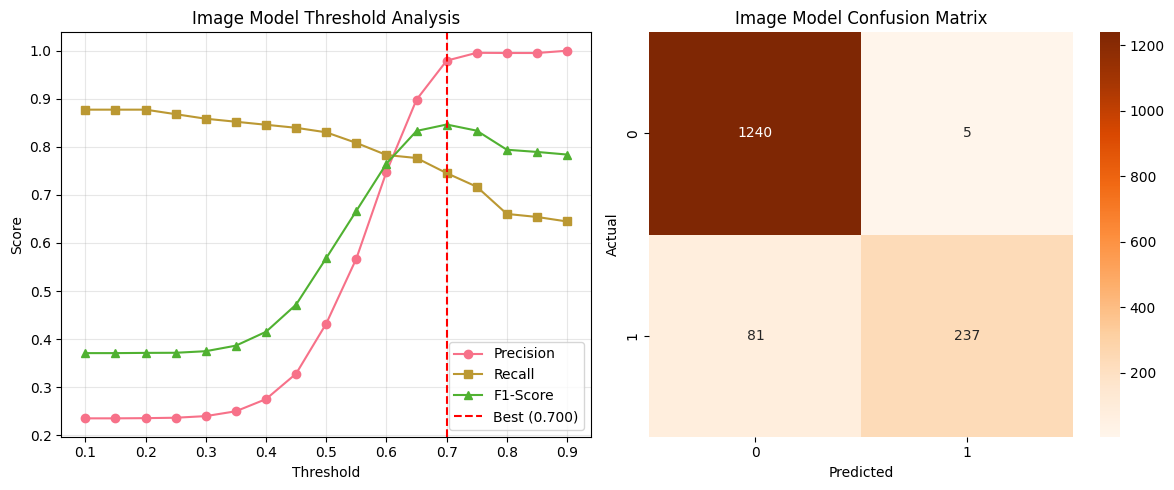


💾 Image model results saved: ../models/image_results.pkl


In [22]:

# Check for missing images (similarity = 0.0)
missing_train = (image_similarities_train == 0.0).sum()
missing_test = (image_similarities_test == 0.0).sum()
print(f"   Missing images: Train={missing_train}/{len(image_similarities_train)}, Test={missing_test}/{len(image_similarities_test)}")

print("\nOptimizing image similarity threshold...")
best_image_threshold, best_image_score, image_threshold_results = find_best_threshold(
    y_test, image_similarities_test, target_metric='f1'
)

print(f"   Best threshold: {best_image_threshold:.3f}")
print(f"   Best F1 score: {best_image_score:.3f}")

# Evaluate image model with best threshold
image_pred = (image_similarities_test >= best_image_threshold).astype(int)

image_accuracy = accuracy_score(y_test, image_pred)
image_precision = precision_score(y_test, image_pred)
image_recall = recall_score(y_test, image_pred)
image_f1 = f1_score(y_test, image_pred)
image_auc = roc_auc_score(y_test, image_similarities_test)

print(f"\nIMAGE MODEL PERFORMANCE:")
print(f"   Threshold:  {best_image_threshold:.3f}")
print(f"   Accuracy:   {image_accuracy:.4f}")
print(f"   Precision:  {image_precision:.4f}")
print(f"   Recall:     {image_recall:.4f}")
print(f"   F1-Score:   {image_f1:.4f}")
print(f"   AUC:        {image_auc:.4f}")

# Quick visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Threshold analysis plot
image_thresholds_df = pd.DataFrame(image_threshold_results)
ax1.plot(image_thresholds_df['threshold'], image_thresholds_df['precision'], label='Precision', marker='o')
ax1.plot(image_thresholds_df['threshold'], image_thresholds_df['recall'], label='Recall', marker='s')
ax1.plot(image_thresholds_df['threshold'], image_thresholds_df['f1'], label='F1-Score', marker='^')
ax1.axvline(x=best_image_threshold, color='red', linestyle='--', label=f'Best ({best_image_threshold:.3f})')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Image Model Threshold Analysis')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Confusion matrix
cm_image = confusion_matrix(y_test, image_pred)
sns.heatmap(cm_image, annot=True, fmt='d', ax=ax2, cmap='Oranges')
ax2.set_title('Image Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('../data/processed/image_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save image model results
image_results = {
    'threshold': best_image_threshold,
    'train_similarities': image_similarities_train,
    'test_similarities': image_similarities_test,
    'test_predictions': image_pred,
    'metrics': {
        'accuracy': image_accuracy,
        'precision': image_precision,
        'recall': image_recall,
        'f1': image_f1,
        'auc': image_auc
    }
}

# Save to models directory
image_path = models_dir / "image_results.pkl"
joblib.dump(image_results, image_path)

print(f"\n💾 Image model results saved: {image_path}")